In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
if "../src" not in sys.path:
    sys.path.append("../src")

In [3]:
import json
from tqdm.auto import tqdm
from itertools import islice
from datetime import datetime
from collections import Counter
from dataclasses import dataclass
import textwrap

import numpy as np
import pandas as pd
from gensim.models import KeyedVectors
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.metrics import classification_report

import torch
from torch.utils.data import Dataset, DataLoader

from morphen.delta_classifier import (
    get_delta_vec,
    feature_extraction,
    estimate_lda,
    estimate_tree)
output_paths = []

## Data dependencies

```
../data/verb_morpho.csv 15c7c1
../data/10.02-word-split.json 7ac81e
../data/delta_tenc_d200_biwords.bin 04e3f4
```

In [4]:
from hashlib import sha1
from pathlib import Path
paths = ["../data/verb_morpho.csv",          
         "../data/10.02-word-split.json",
         "../data/delta_tenc_d200_biwords.bin"]
for path_x in paths:
    h = sha1()
    h.update(Path(path_x).read_bytes())
    print(path_x, h.hexdigest()[:6])

../data/verb_morpho.csv 15c7c1
../data/10.02-word-split.json 7ac81e
../data/delta_tenc_d200_biwords.bin 04e3f4


## Load dependencies

In [5]:
mr_data = pd.read_csv("../data/verb_morpho.csv", index_col=0)
kv = KeyedVectors.load_word2vec_format("../data/delta_tenc_d200_biwords.bin", binary=True)
with open("../data/10.02-word-split.json", "r", encoding="UTF-8") as fin:
    word_split = json.load(fin)

## Make dataset

In [6]:
mr_data.iloc[:1, ]

,token,token_simp,source,ASBC,Apple (2006-2016),China (2015-2016),Dcard (2019-2020),PTT (2004-2019),MorphoSyntax
4073,丟來,丢来,Corpus,1.0,5.0,5.0,1.0,0.0,VR


In [7]:
## for compatibility with 20.11 and morphen/delta_classifier:feature_extraction
mr_data = mr_data.assign(token_key=mr_data.token)

In [8]:
mr_data.shape

(1676, 10)

## Delta machine

In [10]:
mr_data_train = mr_data.loc[mr_data.token.isin(word_split["train"]),:]
mr_data_test = mr_data.loc[mr_data.token.isin(word_split["test"]),:]

In [11]:
mr_train_entries = mr_data_train.to_dict(orient='records')
mr_test_entries = mr_data_test.to_dict(orient='records')

In [12]:
trainX, trainY = feature_extraction("c1+c2", mr_train_entries, kv)
testX, testY = feature_extraction("c1+c2", mr_test_entries, kv)

In [13]:
trainX.shape, testX.shape

((1240, 400), (304, 400))

In [14]:
# https://github.com/scikit-learn/scikit-learn/blob/36958fb240fbe435673a9e3c52e769f01f36bec0/sklearn/linear_model/_base.py#L408
# scores = safe_sparse_dot(X, self.coef_.T, dense_output=True) + self.intercept_
# return scores.ravel() if scores.shape[1] == 1 else scores
# --
# https://github.com/scikit-learn/scikit-learn/blob/36958fb240fbe435673a9e3c52e769f01f36bec0/sklearn/discriminant_analysis.py#L944
# d = self._decision_function(X)
# y_pred = self.classes_.take(d.argmax(1))

In [16]:
lda = LinearDiscriminantAnalysis()
scaler = MinMaxScaler()
trainX = scaler.fit_transform(trainX)
testX = scaler.transform(testX)
lda.fit(trainX, trainY)
print(lda.score(testX, testY))
coef = lda.coef_
b = lda.intercept_

0.7138157894736842


In [17]:
lda.classes_

array(['AV', 'VO', 'VR', 'VV'], dtype='<U2')

In [19]:
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import matplotlib.pyplot as plt

In [84]:
class EpsilonMachine(nn.Module):
    def __init__(self, lda_coef, lda_b):
        super().__init__()
        n_hidden = 800
        self.fn1 = nn.Sequential(nn.Linear(400, n_hidden), 
                                 nn.Tanh(),
                                 nn.Linear(n_hidden, 400))
        self.lda_coef = lda_coef
        self.lda_b = lda_b
        
    def forward(self, X, labels=None):
        eps = self.fn1(X)
        vhat = X + eps        
        lda_logits = vhat.matmul(self.lda_coef.t()) + self.lda_b        
        if labels is not None:
            loss =  F.cross_entropy(lda_logits, labels)
            return eps, loss
        return eps, None
        

In [90]:
torch.manual_seed(1234)
model = EpsilonMachine(torch.tensor(coef).float(), torch.tensor(b).float())
label_map = {x: i for i, x in enumerate(lda.classes_)}
train_labelids = [label_map[x] for x in trainY]
loss_vec = []
train_acc = []
test_acc = []
acc_xs = []
optimizer = optim.SGD(model.parameters(), lr=1e-4)

In [91]:
for epoch_i in tqdm(range(1200)):    
    optimizer.zero_grad()
    _, loss = model(torch.tensor(trainX), torch.tensor(train_labelids))    
    loss.backward()
    optimizer.step()    
    loss_vec.append(loss.item())
    
    if (epoch_i+1) % 100 == 0:
        with torch.no_grad():
            train_eps, _ = model(torch.tensor(trainX))
            test_eps, _ = model(torch.tensor(testX))
        acc_xs.append(epoch_i)
        train_acc.append(lda.score(trainX+train_eps.numpy(), trainY))                
        test_acc.append(lda.score(testX+test_eps.numpy(), testY))

  0%|          | 0/1200 [00:00<?, ?it/s]

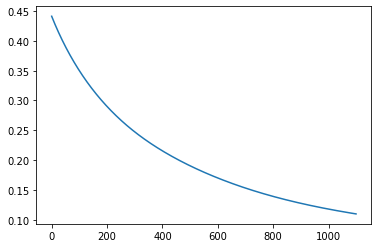

In [92]:
plt.plot(loss_vec[100:])

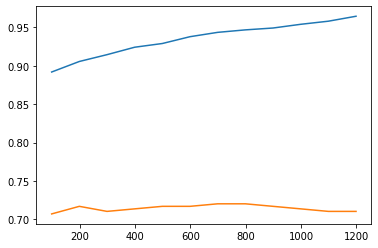

In [93]:
plt.plot(acc_xs, train_acc)
plt.plot(acc_xs, test_acc)

In [94]:
with torch.no_grad():
    train_eps, _ = model(torch.tensor(trainX))
    test_eps, _ = model(torch.tensor(testX))
print("[Train] origin: ", lda.score(trainX, trainY))
print("[Train] origin+eps: ", lda.score(trainX+train_eps.numpy(), trainY))
print("[Test] origin: ", lda.score(testX, testY))
print("[Test] origin+eps: ", lda.score(testX+test_eps.numpy(), testY))

[Train] origin:  0.9330645161290323
[Train] origin+eps:  0.964516129032258
[Test] origin:  0.7138157894736842
[Test] origin+eps:  0.7105263157894737
